## 获取MNIST数据

### torchvision.transforms带有数据变换（数据增广）
transforms.Compose将多个数据变换组合成一个序列，以便轻松地对数据进行一系列处理
1. ToTensor()：将图像从PIL格式或范围[0, 255]的numpy数组转换为PyTorch张量，并将像素值缩放到范围[0, 1]。
2. Normalize()：对图像进行标准化，通常用均值和标准差。这对于确保神经网络的输入数据具有相似的范围非常重要。
3. RandomHorizontalFlip()：以一定概率随机水平翻转图像，用于数据增强。
4. RandomCrop()：以随机位置裁剪图像，用于数据增强。
5. Resize()：调整图像的尺寸。

In [4]:
import torch
from torchvision import datasets, transforms

# transforms.Compose将多个数据变换组合成一个序列，以便轻松地对数据进行一系列处理
transform = transforms.Compose([transforms.ToTensor()])

# 下载和加载MNIST数据集
train_dataset = datasets.MNIST(root='./torch_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./torch_data', train=False, transform=transform, download=True)

# 添加验证集
val_size=500
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])

# 创建数据加载器:DataLoader对象会动态加载数据批次
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ./torch_data\MNIST\raw\train-images-idx3-ubyte.gz to ./torch_data\MNIST\raw



100.0%


Extracting ./torch_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./torch_data\MNIST\raw



100.0%


Extracting ./torch_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./torch_data\MNIST\raw



100.0%

Extracting ./torch_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./torch_data\MNIST\raw



### 可视化数据

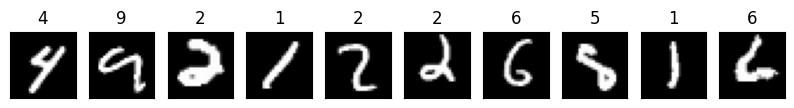

In [5]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)
plt.figure(figsize=(10, 5))
for i,image in enumerate(images[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i].item()}")
plt.show()

## autoencoder网络：全连接层

In [6]:
import torch
from torch import nn
print(images.shape)
#图片输入:(batch,1,28*28)

class AutoEncoderFullyConnect(nn.Module):
    def __init__(self,input_size=28*28,hidden_size=32):
        super().__init__()
        self.fc1=nn.Linear(input_size, hidden_size)
        self.encoder=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,input_size)
        self.decoder=nn.Sigmoid()

    def forward(self,x):
        x=self.fc1(x)
        x=self.encoder(x)
        x=self.fc2(x)
        x=self.decoder(x)
        return x


auto_encoder_model=AutoEncoderFullyConnect()

torch.Size([64, 1, 28, 28])


In [7]:
#第二种定义的方法

# class AutoEncoderFullyConnect(nn.Module):
#     def __init__(self,input_size=28*28,hidden_size=32):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_size, input_size),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

## 训练

In [11]:
#处理输入数据28*28，平铺
def preprocess(x):
    #其实是不用的，前面已经预处理过了transforms.ToTensor()
    # x = x.float() / 255.0 
    return x.reshape(-1, x.size()[1:].numel()) # flatten

#训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
auto_encoder_model.to(device)  # 将模型移到GPU（如果可用）

# 创建二元交叉熵损失函数
# 但是要注意预测值和真实值要在[0,1]
criterion = nn.BCELoss()
# Adam优化器
optimizer=torch.optim.Adam(auto_encoder_model.parameters())
num_epochs = 10  # 根据需要调整训练周期

for epoch in range(num_epochs):
    # 切换到训练模式
    auto_encoder_model.train()  
    running_train_loss = 0.0
    for images,labels in train_loader:
        optimizer.zero_grad()  # 清零梯度
        outputs = auto_encoder_model(preprocess(images).to(device))  # 输入数据到模型
        loss = criterion(outputs, preprocess(images).to(device))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader) 

    # 在验证集上计算损失
    auto_encoder_model.eval()  # 切换到评估模式
    running_val_loss = 0.0
    for images,labels in val_loader:
        outputs = auto_encoder_model(preprocess(images).to(device))
        loss = criterion(outputs, preprocess(images).to(device))
        running_val_loss += loss.item()
    val_loss = running_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')


Epoch [1/10] - Train Loss: 0.1009 - Validation Loss: 0.0999
Epoch [2/10] - Train Loss: 0.1006 - Validation Loss: 0.0999
Epoch [3/10] - Train Loss: 0.1005 - Validation Loss: 0.1001
Epoch [4/10] - Train Loss: 0.1004 - Validation Loss: 0.0998
Epoch [5/10] - Train Loss: 0.1003 - Validation Loss: 0.0996
Epoch [6/10] - Train Loss: 0.1003 - Validation Loss: 0.0996
Epoch [7/10] - Train Loss: 0.1003 - Validation Loss: 0.0997
Epoch [8/10] - Train Loss: 0.1002 - Validation Loss: 0.0996
Epoch [9/10] - Train Loss: 0.1002 - Validation Loss: 0.0995
Epoch [10/10] - Train Loss: 0.1002 - Validation Loss: 0.0993


## 非常灵活的选择模型的部分

注意模型选择
- auto_encoder_model.encoder这样选择的只是模型对应的运算单元encoder
- self.encoder=nn.ReLU()
- 实际选择的是nn.ReLU()
- 下面这些在模型1中都是值选择了一个运算节点    
    fc1=auto_encoder_model.fc1
    
    fc2=auto_encoder_model.fc2

    encoder = auto_encoder_model.encoder

    decoder = auto_encoder_model.decoder
- 模型2中定义的不一样

    包括了里面的所有运算
    
    self.encoder = nn.Sequential(

            nn.Linear(input_size, hidden_size),

            nn.ReLU()

        )
        
    auto_encoder_model.encoder(x)

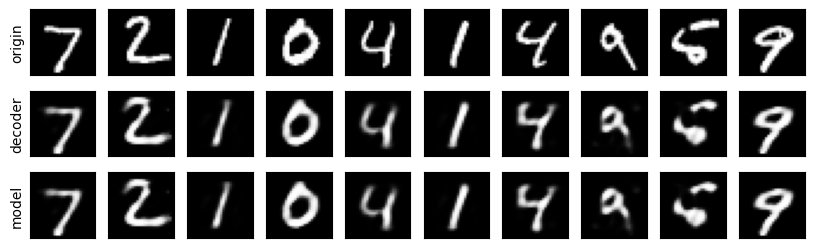

In [12]:
import math

#可视化效果，选择需要对比的图片，其中的10张
def show_images(*images_args):
    num_categories=len(images_args)
    plt.figure(figsize=(10, num_categories))
    #多个类别
    for c,(images,category) in enumerate(images_args):
        #其中的10张
        for i in range(10):
            plt.subplot(num_categories, 10, c*10+i+1)
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                # 添加y轴标签
                plt.ylabel(category)
    plt.show()

fc1=auto_encoder_model.fc1
encoder = auto_encoder_model.encoder
fc2=auto_encoder_model.fc2
decoder = auto_encoder_model.decoder

fc1_net=fc1
encoder_net=nn.Sequential(fc1,encoder)
fc2_net=nn.Sequential(fc1,encoder,fc2)
decoder_net=nn.Sequential(fc1,encoder,fc2,decoder)

test_data_iter = iter(test_loader)
test_images, test_labels = next(test_data_iter)
fc1_output=fc1_net(preprocess(test_images).to(device)).cpu().detach().numpy()
encoder_output=encoder_net(preprocess(test_images).to(device)).cpu().detach().numpy()
fc2_output=fc2_net(preprocess(test_images).to(device)).cpu().detach().numpy()
decoder_output=decoder_net(preprocess(test_images).to(device)).cpu().detach().numpy()
model_output=auto_encoder_model(preprocess(test_images).to(device)).cpu().detach().numpy()
show_images((test_images,'origin'),(decoder_output,'decoder'),(model_output,'model'))


## 验证降噪
训练：
- 在训练的原始数据中加入噪音
- 噪音数据和原始数据求损失函数

推理：
- 输入噪音数据，得到降噪数据


In [13]:
#加入噪音
def add_noise(x, noise_factor=0.2):
    noise = torch.randn_like(x) * noise_factor
    noisy_x = x + noise
    noisy_x = torch.clamp(noisy_x, 0.0, 1.0)  # 将像素值限制在 [0, 1] 范围内
    return noisy_x

#重新训练
for epoch in range(num_epochs):
    # 切换到训练模式
    auto_encoder_model.train()  
    running_train_loss = 0.0
    for images,labels in train_loader:
        optimizer.zero_grad()  # 清零梯度
        outputs = auto_encoder_model(add_noise(preprocess(images)).to(device))  # 输入数据到模型
        loss = criterion(outputs, preprocess(images).to(device))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader) 

    # 在验证集上计算损失
    auto_encoder_model.eval()  # 切换到评估模式
    running_val_loss = 0.0
    for images,labels in val_loader:
        outputs = auto_encoder_model(add_noise(preprocess(images)).to(device))
        loss = criterion(outputs, preprocess(images).to(device))
        running_val_loss += loss.item()
    val_loss = running_val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch [1/10] - Train Loss: 0.1079 - Validation Loss: 0.1060
Epoch [2/10] - Train Loss: 0.1060 - Validation Loss: 0.1051
Epoch [3/10] - Train Loss: 0.1057 - Validation Loss: 0.1049
Epoch [4/10] - Train Loss: 0.1056 - Validation Loss: 0.1047
Epoch [5/10] - Train Loss: 0.1055 - Validation Loss: 0.1051
Epoch [6/10] - Train Loss: 0.1055 - Validation Loss: 0.1050
Epoch [7/10] - Train Loss: 0.1055 - Validation Loss: 0.1047
Epoch [8/10] - Train Loss: 0.1054 - Validation Loss: 0.1045
Epoch [9/10] - Train Loss: 0.1054 - Validation Loss: 0.1043
Epoch [10/10] - Train Loss: 0.1054 - Validation Loss: 0.1049


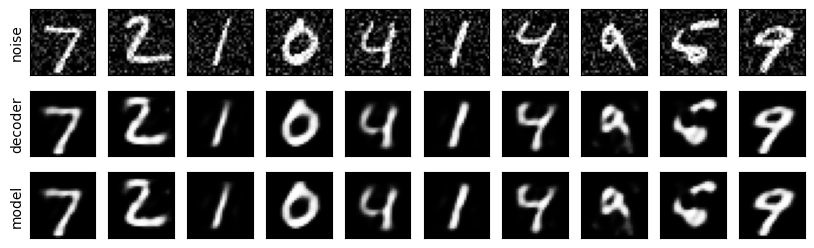

In [14]:
nosie_images=add_noise(test_images)
fc1_output=fc1_net(preprocess(nosie_images).to(device)).cpu().detach().numpy()
encoder_output=encoder_net(preprocess(nosie_images).to(device)).cpu().detach().numpy()
fc2_output=fc2_net(preprocess(nosie_images).to(device)).cpu().detach().numpy()
decoder_output=decoder_net(preprocess(nosie_images).to(device)).cpu().detach().numpy()
model_output=auto_encoder_model(preprocess(nosie_images).to(device)).cpu().detach().numpy()
show_images((nosie_images,'noise'),(decoder_output,'decoder'),(model_output,'model'))

## 卷积层的autoencoder
注意：
1. nn.Upsample(size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None)

    上采样的操作，将输入的图像或特征图的尺寸增大，通常使用**插值**来填充新的像素。**不是转置卷积**

2. nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

    padding是int或者tuple，**不支持str，这一点和nn.Conv2d不一样**

In [15]:
class AutoEncoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            #  都可以，设置padding来调整shape更好
            nn.MaxPool2d(kernel_size=2,padding=1),
            # nn.MaxPool2d(kernel_size=2,ceil_mode=True),
        )
        self.decoder=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding='same'),
            nn.Sigmoid()
        )

    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
        
auto_encoder_conv_model=AutoEncoderConv().to(device)    


## pytorch 打印模型结构

In [16]:
import torchsummary
#device参数，模型所在的设备，可以是 "cpu" 或 "cuda"。默认是 "cuda"，所以模型也要在cuda
torchsummary.summary(auto_encoder_conv_model,input_size=(1,28,28),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 28, 28]             160
              ReLU-2           [64, 16, 28, 28]               0
         MaxPool2d-3           [64, 16, 14, 14]               0
            Conv2d-4            [64, 8, 14, 14]           1,160
              ReLU-5            [64, 8, 14, 14]               0
         MaxPool2d-6              [64, 8, 7, 7]               0
            Conv2d-7              [64, 8, 7, 7]             584
              ReLU-8              [64, 8, 7, 7]               0
         MaxPool2d-9              [64, 8, 4, 4]               0
           Conv2d-10              [64, 8, 4, 4]             584
             ReLU-11              [64, 8, 4, 4]               0
         Upsample-12              [64, 8, 8, 8]               0
           Conv2d-13              [64, 8, 8, 8]             584
             ReLU-14              [64, 

## 训练

In [17]:
optimizer=torch.optim.Adam(auto_encoder_conv_model.parameters())
for epoch in range(num_epochs):
    # 切换到训练模式
    auto_encoder_conv_model.train()  
    running_train_loss = 0.0
    for images,labels in train_loader:
        optimizer.zero_grad()  # 清零梯度
        outputs = auto_encoder_conv_model(images.to(device))  # 输入数据到模型
        loss = criterion(outputs, images.to(device))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader) 

    # 在验证集上计算损失
    auto_encoder_conv_model.eval()  # 切换到评估模式
    running_val_loss = 0.0
    for images,labels in val_loader:
        outputs = auto_encoder_conv_model(images.to(device))
        loss = criterion(outputs, images.to(device))
        running_val_loss += loss.item()
    val_loss = running_val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch [1/10] - Train Loss: 0.1889 - Validation Loss: 0.1260
Epoch [2/10] - Train Loss: 0.1199 - Validation Loss: 0.1137
Epoch [3/10] - Train Loss: 0.1118 - Validation Loss: 0.1080
Epoch [4/10] - Train Loss: 0.1077 - Validation Loss: 0.1050
Epoch [5/10] - Train Loss: 0.1050 - Validation Loss: 0.1031
Epoch [6/10] - Train Loss: 0.1032 - Validation Loss: 0.1014
Epoch [7/10] - Train Loss: 0.1018 - Validation Loss: 0.1002
Epoch [8/10] - Train Loss: 0.1006 - Validation Loss: 0.0991
Epoch [9/10] - Train Loss: 0.0995 - Validation Loss: 0.0983
Epoch [10/10] - Train Loss: 0.0986 - Validation Loss: 0.0970


## 测试效果如何

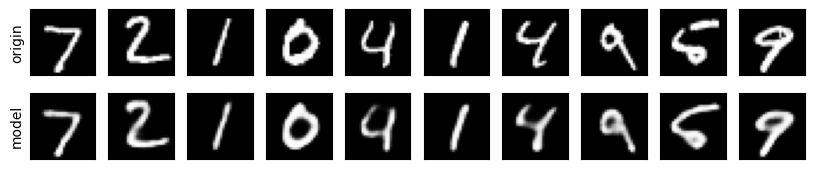

In [18]:
model_output=auto_encoder_conv_model(test_images.to(device)).cpu().detach().numpy()
show_images((test_images,'origin'),(model_output,'model'))

## 测试一下降噪

In [19]:
#训练
for epoch in range(num_epochs):
    # 切换到训练模式
    auto_encoder_conv_model.train()  
    running_train_loss = 0.0
    for images,labels in train_loader:
        optimizer.zero_grad()  # 清零梯度
        outputs = auto_encoder_conv_model(add_noise(images).to(device))  # 输入数据到模型
        loss = criterion(outputs, images.to(device))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader) 

    # 在验证集上计算损失
    auto_encoder_conv_model.eval()  # 切换到评估模式
    running_val_loss = 0.0
    for images,labels in val_loader:
        outputs = auto_encoder_conv_model(add_noise(images).to(device))
        loss = criterion(outputs, images.to(device))
        running_val_loss += loss.item()
    val_loss = running_val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch [1/10] - Train Loss: 0.1067 - Validation Loss: 0.1032
Epoch [2/10] - Train Loss: 0.1035 - Validation Loss: 0.1021
Epoch [3/10] - Train Loss: 0.1027 - Validation Loss: 0.1014
Epoch [4/10] - Train Loss: 0.1020 - Validation Loss: 0.1011
Epoch [5/10] - Train Loss: 0.1015 - Validation Loss: 0.1001
Epoch [6/10] - Train Loss: 0.1010 - Validation Loss: 0.1000
Epoch [7/10] - Train Loss: 0.1004 - Validation Loss: 0.0996
Epoch [8/10] - Train Loss: 0.1000 - Validation Loss: 0.0989
Epoch [9/10] - Train Loss: 0.0996 - Validation Loss: 0.0994
Epoch [10/10] - Train Loss: 0.0993 - Validation Loss: 0.0988


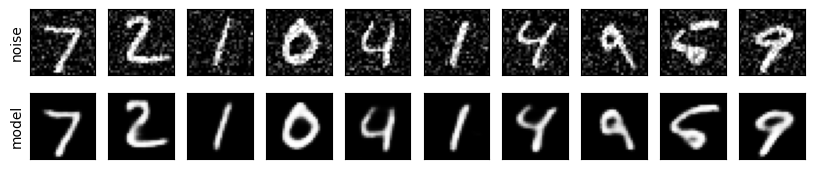

In [20]:
nosie_images=add_noise(test_images)
model_output=auto_encoder_conv_model(nosie_images.to(device)).cpu().detach().numpy()
show_images((nosie_images,'noise'),(model_output,'model'))